In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from easydict import EasyDict as edict
from collections import defaultdict as ddict
from pprint import pprint

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Useful functions

In [2]:
def sortdir(f):
    num = f.name.split("_")[-2].split("p")[-1]
    num = int(num)
    return  num

def sortf(f):
    num = f.name.split(".")[0]
    num = int(num)
    return num

In [3]:
def load_pkl(f):
    with open(f, "rb") as fi:
        data = pickle.load(fi)
    return data

### Linestyles for plot

In [4]:
linestyles = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.'
    
     ('loosely dotted',        (0, (1, 10))),
     ('densely dotted',        (0, (1, 1))),
    
     ('loosely dashed',        (0, (5, 10))),
     ('densely dashed',        (0, (5, 1))),

     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

### Functions for sizes and powers

In [5]:
def is_true(theta0, bs):
    low, up = bs
    return (theta0 > low) and (theta0 < up)


def rejrate(theta0, data, theta):
    reslist = [is_true(theta0, bs=[np.quantile(dat, q=theta), np.quantile(dat, q=1-theta)]) for dat in data] 
    return 1 - np.mean(reslist)


def getRatio(theta0, data):
    p1 = np.mean(data<=theta0)
    p2 = np.mean(data>theta0)
    res = np.min([p1, p2])
    return res



def getQuantile(theta0, data, alp=0.05):
    res = [getRatio(theta0, data=dat) for dat in data]
    return np.quantile(res, q=alp)

# A. n=60

## 1. load data

In [6]:
n = 60
root = Path(f"./results/")

fls = root.glob(f"SimBiostatR1*_n{n}.pkl")
fls = list(fls)
fls = sorted(fls, key=sortdir)
idxs = [int(sortdir(fl))/100 for fl in fls] 

## 2. Obtain the sizes

In [7]:
sizes60 = ddict(list)
for cfl, theta0 in zip(fls, idxs):
    cleanData = load_pkl(cfl)
    for key, dat in cleanData.items():
        sizes60[key].append(rejrate(theta0, dat, 0.025))

## 3. Obtain the powers when $\theta_0=0$

In [8]:
theta0 = 0
cfl = fls[idxs.index(theta0)]

In [9]:
cfl

PosixPath('results/SimBiostatR1_p0_n60.pkl')

### Get the critical values

In [10]:
CVqs60= ddict(float)
Alphas60 = ddict(float)
cleanData = load_pkl(cfl)
alps = {
    "JEF": 0.05 - 1e-3,
    "FULL": 0.05,
    "LCP": 0.05 - 1e-3,
    "UIPJS": 0.05 - 1e-3,
    "UIPD": 0.05 - 5e-4,
    "NPP": 0.05 - 1e-3,
    "rMAP": 0.05 - 5e-4
}
for key, dat in cleanData.items():
    CVqs60[key] = getQuantile(theta0, data=dat, alp=alps[key])
    Alphas60[key] = rejrate(theta0, dat, CVqs60[key])
    
print("Sizes after calibrating")
for key, v in Alphas60.items():
    print(f"{key:<10}: {v:.3f}")


Sizes after calibrating
JEF       : 0.050
FULL      : 0.997
LCP       : 0.050
NPP       : 0.050
UIPJS     : 0.050
UIPD      : 0.050
rMAP      : 0.050


In [11]:
CVqs60

defaultdict(float,
            {'JEF': 0.0185951,
             'FULL': 0.0,
             'LCP': 0.00369755,
             'NPP': 0.00055,
             'UIPJS': 0.0031255000000000002,
             'UIPD': 0.003290100000000001,
             'rMAP': 0.01599505})

### Get the powers

In [12]:
Powers60 = ddict(list)
Powers95_60 = ddict(list)

In [13]:
for cfl, theta in zip(fls, idxs):
    Powers60["theta"].append(theta)
    Powers95_60["theta"].append(theta)
    datah1 = load_pkl(cfl)
    print(cfl)
    for key, dat in datah1.items():
        Powers60[key].append(rejrate(theta0, dat, CVqs60[key]))
        Powers95_60[key].append(rejrate(theta0, dat, 0.025))

results/SimBiostatR1_p0_n60.pkl
results/SimBiostatR1_p10_n60.pkl
results/SimBiostatR1_p20_n60.pkl
results/SimBiostatR1_p30_n60.pkl
results/SimBiostatR1_p40_n60.pkl
results/SimBiostatR1_p50_n60.pkl
results/SimBiostatR1_p60_n60.pkl
results/SimBiostatR1_p70_n60.pkl
results/SimBiostatR1_p80_n60.pkl
results/SimBiostatR1_p90_n60.pkl
results/SimBiostatR1_p100_n60.pkl


In [14]:
Powers60 = pd.DataFrame(Powers60)
print(Powers60)
print(f"Powers after calibrating")
print(Powers60.drop(columns=["theta"]).mean(axis=0))
print("Sizes")
for key, v in Alphas60.items():
    print(f"{key:<10}: {v:.3f}")

    theta    JEF   FULL    LCP    NPP  UIPJS   UIPD   rMAP
0     0.0  0.050  0.997  0.050  0.050  0.050  0.050  0.050
1     0.1  0.115  0.999  0.170  0.160  0.177  0.171  0.156
2     0.2  0.271  1.000  0.374  0.365  0.396  0.382  0.359
3     0.3  0.586  0.998  0.684  0.666  0.726  0.701  0.676
4     0.4  0.829  1.000  0.880  0.887  0.899  0.890  0.877
5     0.5  0.952  1.000  0.970  0.972  0.978  0.975  0.973
6     0.6  0.990  1.000  0.996  0.994  0.997  0.997  0.997
7     0.7  1.000  1.000  1.000  1.000  1.000  1.000  1.000
8     0.8  1.000  1.000  1.000  1.000  1.000  1.000  1.000
9     0.9  1.000  1.000  1.000  1.000  1.000  1.000  1.000
10    1.0  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Powers after calibrating
JEF      0.708455
FULL     0.999455
LCP      0.738545
NPP      0.735818
UIPJS    0.747545
UIPD     0.742364
rMAP     0.735273
dtype: float64
Sizes
JEF       : 0.050
FULL      : 0.997
LCP       : 0.050
NPP       : 0.050
UIPJS     : 0.050
UIPD      : 0.050
rMAP      : 

In [15]:
Powers95_60 = pd.DataFrame(Powers95_60)
print(Powers95_60)
print(f"Powers95")
print(Powers95_60.drop(columns=["theta"]).mean(axis=0))
print("Sizes")
for key, v in sizes60.items():
    print(f"{key:<10}: {v[0]:.3f}")

    theta    JEF  FULL    LCP    NPP  UIPJS   UIPD   rMAP
0     0.0  0.066   1.0  0.144  0.296  0.169  0.155  0.069
1     0.1  0.140   1.0  0.339  0.582  0.399  0.377  0.200
2     0.2  0.325   1.0  0.639  0.811  0.696  0.686  0.437
3     0.3  0.638   1.0  0.880  0.957  0.913  0.908  0.742
4     0.4  0.859   1.0  0.961  0.994  0.976  0.974  0.908
5     0.5  0.964   1.0  0.996  0.999  0.997  0.997  0.980
6     0.6  0.994   1.0  0.999  1.000  1.000  0.999  0.998
7     0.7  1.000   1.0  1.000  1.000  1.000  1.000  1.000
8     0.8  1.000   1.0  1.000  1.000  1.000  1.000  1.000
9     0.9  1.000   1.0  1.000  1.000  1.000  1.000  1.000
10    1.0  1.000   1.0  1.000  1.000  1.000  1.000  1.000
Powers95
JEF      0.726000
FULL     1.000000
LCP      0.814364
NPP      0.876273
UIPJS    0.831818
UIPD     0.826909
rMAP     0.757636
dtype: float64
Sizes
JEF       : 0.066
FULL      : 1.000
LCP       : 0.144
NPP       : 0.296
UIPJS     : 0.169
UIPD      : 0.155
rMAP      : 0.069


# B. n=120

## 1. load data

In [16]:
n = 120
root = Path(f"./results/")

fls = root.glob(f"SimBiostatR1*_n{n}.pkl")
fls = list(fls)
fls = sorted(fls, key=sortdir)
idxs = [int(sortdir(fl))/100 for fl in fls] 

## 2. Obtain the sizes

In [17]:
sizes120 = ddict(list)
for cfl, theta0 in zip(fls, idxs):
    cleanData = load_pkl(cfl)
    for key, dat in cleanData.items():
        sizes120[key].append(rejrate(theta0, dat, 0.025))

## 3. Obtain the powers when $\theta_0=0$

In [18]:
theta0 = 0
cfl = fls[idxs.index(theta0)]

In [19]:
cfl

PosixPath('results/SimBiostatR1_p0_n120.pkl')

### Get the critical values

In [20]:
CVqs120= ddict(float)
Alphas120 = ddict(float)
cleanData = load_pkl(cfl)
alps = {
    "JEF": 0.05 - 1e-3,
    "FULL": 0.05,
    "LCP": 0.05 - 1e-3,
    "UIPJS": 0.05 - 5e-4,
    "UIPD": 0.05 - 5e-4,
    "NPP": 0.05 - 1e-3,
    "rMAP": 0.05 - 5e-4
}
for key, dat in cleanData.items():
    CVqs120[key] = getQuantile(theta0, data=dat, alp=alps[key])
    Alphas120[key] = rejrate(theta0, dat, CVqs120[key])
    
print("Sizes after calibrating")
for key, v in Alphas120.items():
    print(f"{key:<10}: {v:.3f}")


Sizes after calibrating
JEF       : 0.050
FULL      : 0.962
LCP       : 0.050
NPP       : 0.051
UIPJS     : 0.051
UIPD      : 0.050
rMAP      : 0.050


In [21]:
CVqs120

defaultdict(float,
            {'JEF': 0.0264902,
             'FULL': 0.0,
             'LCP': 0.0126255,
             'NPP': 0.0045451,
             'UIPJS': 0.01025,
             'UIPD': 0.008912625000000002,
             'rMAP': 0.025380200000000002})

### Get the powers

In [22]:
Powers120 = ddict(list)
Powers95_120 = ddict(list)

In [23]:
for cfl, theta in zip(fls, idxs):
    Powers120["theta"].append(theta)
    Powers95_120["theta"].append(theta)
    datah1 = load_pkl(cfl)
    print(cfl)
    for key, dat in datah1.items():
        Powers120[key].append(rejrate(theta0, dat, CVqs120[key]))
        Powers95_120[key].append(rejrate(theta0, dat, 0.025))

results/SimBiostatR1_p0_n120.pkl
results/SimBiostatR1_p10_n120.pkl
results/SimBiostatR1_p20_n120.pkl
results/SimBiostatR1_p30_n120.pkl
results/SimBiostatR1_p40_n120.pkl
results/SimBiostatR1_p50_n120.pkl
results/SimBiostatR1_p60_n120.pkl
results/SimBiostatR1_p70_n120.pkl
results/SimBiostatR1_p80_n120.pkl
results/SimBiostatR1_p90_n120.pkl
results/SimBiostatR1_p100_n120.pkl


In [24]:
Powers120 = pd.DataFrame(Powers120)
print(Powers120)
print(f"Powers after calibrating")
print(Powers120.drop(columns=["theta"]).mean(axis=0))
print("Sizes")
for key, v in Alphas120.items():
    print(f"{key:<10}: {v:.3f}")

    theta    JEF   FULL    LCP    NPP  UIPJS   UIPD   rMAP
0     0.0  0.050  0.962  0.050  0.051  0.051  0.050  0.050
1     0.1  0.220  0.995  0.283  0.320  0.298  0.313  0.272
2     0.2  0.632  1.000  0.691  0.736  0.720  0.736  0.704
3     0.3  0.909  1.000  0.935  0.955  0.948  0.951  0.945
4     0.4  0.983  1.000  0.990  0.990  0.990  0.991  0.992
5     0.5  1.000  1.000  1.000  1.000  1.000  1.000  1.000
6     0.6  1.000  1.000  1.000  1.000  1.000  1.000  1.000
7     0.7  1.000  1.000  1.000  1.000  1.000  1.000  1.000
8     0.8  1.000  1.000  1.000  1.000  1.000  1.000  1.000
9     0.9  1.000  1.000  1.000  1.000  1.000  1.000  1.000
10    1.0  1.000  1.000  1.000  1.000  1.000  1.000  1.000
Powers after calibrating
JEF      0.799455
FULL     0.996091
LCP      0.813545
NPP      0.822909
UIPJS    0.818818
UIPD     0.821909
rMAP     0.814818
dtype: float64
Sizes
JEF       : 0.050
FULL      : 0.962
LCP       : 0.050
NPP       : 0.051
UIPJS     : 0.051
UIPD      : 0.050
rMAP      : 

In [25]:
Powers95_120 = pd.DataFrame(Powers95_120)
print(Powers95_120)
print(f"Powers95")
print(Powers95_120.drop(columns=["theta"]).mean(axis=0))
print("Sizes")
for key, v in sizes120.items():
    print(f"{key:<10}: {v[0]:.3f}")

    theta    JEF  FULL    LCP    NPP  UIPJS   UIPD   rMAP
0     0.0  0.045   1.0  0.087  0.163  0.099  0.112  0.049
1     0.1  0.212   1.0  0.367  0.558  0.413  0.456  0.272
2     0.2  0.614   1.0  0.779  0.868  0.818  0.833  0.703
3     0.3  0.905   1.0  0.964  0.991  0.977  0.981  0.944
4     0.4  0.983   1.0  0.992  0.999  0.995  0.997  0.992
5     0.5  1.000   1.0  1.000  1.000  1.000  1.000  1.000
6     0.6  1.000   1.0  1.000  1.000  1.000  1.000  1.000
7     0.7  1.000   1.0  1.000  1.000  1.000  1.000  1.000
8     0.8  1.000   1.0  1.000  1.000  1.000  1.000  1.000
9     0.9  1.000   1.0  1.000  1.000  1.000  1.000  1.000
10    1.0  1.000   1.0  1.000  1.000  1.000  1.000  1.000
Powers95
JEF      0.796273
FULL     1.000000
LCP      0.835364
NPP      0.870818
UIPJS    0.845636
UIPD     0.852636
rMAP     0.814545
dtype: float64
Sizes
JEF       : 0.045
FULL      : 1.000
LCP       : 0.087
NPP       : 0.163
UIPJS     : 0.099
UIPD      : 0.112
rMAP      : 0.049


# C. Plot the curves

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

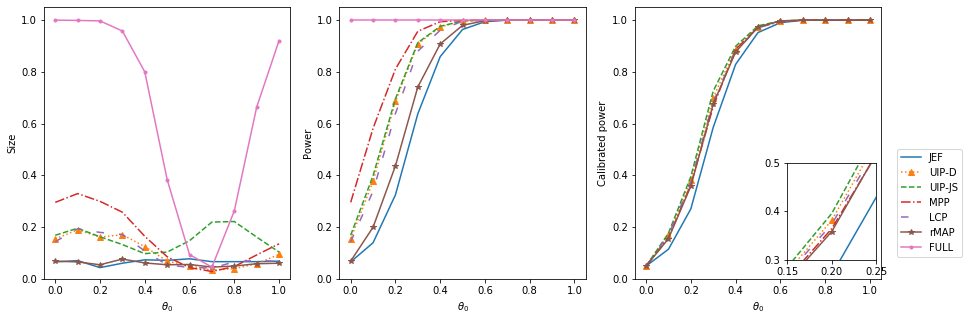

In [27]:
thetas = idxs
fig = plt.figure(figsize=[15, 5])
axes = fig.subplots(1, 3)

#axes[0].set_title("Sizes")
axes[0].set_ylim([0, 1.05])
axes[0].set_xlabel(r"$\theta_0$")
axes[0].set_ylabel("Size")
axes[0].plot(thetas, sizes60["JEF"], label="JEF", linestyle=linestyles[0][1])
axes[0].plot(thetas, sizes60["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axes[0].plot(thetas, sizes60["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axes[0].plot(thetas, sizes60["NPP"], label="MPP", linestyle=linestyles[3][1])
axes[0].plot(thetas, sizes60["LCP"], label="LCP", linestyle=linestyles[6][1])
axes[0].plot(thetas, sizes60["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[0].plot(thetas, sizes60["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")


#axes[1].set_title("Powers")
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel(r"$\theta_0$")
axes[1].set_ylabel("Power")
axes[1].plot(thetas, Powers95_60["JEF"], label="JEF", linestyle=linestyles[0][1])
axes[1].plot(thetas, Powers95_60["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axes[1].plot(thetas, Powers95_60["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axes[1].plot(thetas, Powers95_60["NPP"], label="MPP", linestyle=linestyles[3][1])
axes[1].plot(thetas, Powers95_60["LCP"], label="LCP", linestyle=linestyles[6][1])
axes[1].plot(thetas, Powers95_60["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[1].plot(thetas, Powers95_60["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")

#axes[2].set_title("Calibrated powers")
axes[2].set_ylim([0, 1.05])
axes[2].set_xlabel(r"$\theta_0$")
axes[2].set_ylabel("Calibrated power")
axes[2].plot(thetas, Powers60["JEF"], label="JEF", linestyle=linestyles[0][1])
axes[2].plot(thetas, Powers60["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axes[2].plot(thetas, Powers60["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axes[2].plot(thetas, Powers60["NPP"], label="MPP", linestyle=linestyles[3][1])
axes[2].plot(thetas, Powers60["LCP"], label="LCP", linestyle=linestyles[6][1])
axes[2].plot(thetas, Powers60["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
#axes[2].plot(thetas, Powers60["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")

axins = inset_axes(axes[2], width="40%", height="30%", loc='lower right',
                   bbox_to_anchor=(0.1, 0.05, 0.9, 1.2),
                   bbox_transform=axes[2].transAxes)

axins.set_ylim([0.3, 0.5])
axins.set_yticks([0.3, 0.4, 0.5])
axins.set_xlim([0.15, 0.25])
axins.set_xticks([0.15, 0.20, 0.25])
axins.plot(thetas, Powers60["JEF"], label="JEF", linestyle=linestyles[0][1])
axins.plot(thetas, Powers60["UIPD"], label="UIPD", linestyle=linestyles[1][1], marker="^")
axins.plot(thetas, Powers60["UIPJS"], label="UIPJS", linestyle=linestyles[2][1])
axins.plot(thetas, Powers60["NPP"], label="NPP", linestyle=linestyles[3][1])
axins.plot(thetas, Powers60["LCP"], label="LCP", linestyle=linestyles[6][1])
axins.plot(thetas, Powers60["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
axins.plot(thetas, Powers60["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")

handles, labels = axes[0].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc=(0.92, 0.20))

plt.savefig("../plots/cmpNormTest60_long.pdf")

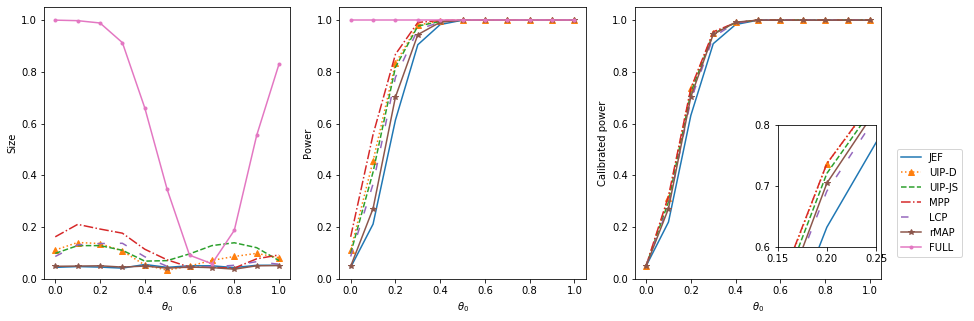

In [28]:
thetas = idxs
fig = plt.figure(figsize=[15, 5])
axes = fig.subplots(1, 3)

#axes[0].set_title("Sizes")
axes[0].set_ylim([0, 1.05])
axes[0].set_xlabel(r"$\theta_0$")
axes[0].set_ylabel("Size")
axes[0].plot(thetas, sizes120["JEF"], label="JEF", linestyle=linestyles[0][1])
axes[0].plot(thetas, sizes120["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axes[0].plot(thetas, sizes120["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axes[0].plot(thetas, sizes120["NPP"], label="MPP", linestyle=linestyles[3][1])
axes[0].plot(thetas, sizes120["LCP"], label="LCP", linestyle=linestyles[6][1])
axes[0].plot(thetas, sizes120["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[0].plot(thetas, sizes120["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")


#axes[1].set_title("Powers")
axes[1].set_ylim([0, 1.05])
axes[1].set_xlabel(r"$\theta_0$")
axes[1].set_ylabel("Power")
axes[1].plot(thetas, Powers95_120["JEF"], label="JEF", linestyle=linestyles[0][1])
axes[1].plot(thetas, Powers95_120["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axes[1].plot(thetas, Powers95_120["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axes[1].plot(thetas, Powers95_120["NPP"], label="MPP", linestyle=linestyles[3][1])
axes[1].plot(thetas, Powers95_120["LCP"], label="LCP", linestyle=linestyles[6][1])
axes[1].plot(thetas, Powers95_120["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
axes[1].plot(thetas, Powers95_120["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")

#axes[2].set_title("Calibrated powers")
axes[2].set_ylim([0, 1.05])
axes[2].set_xlabel(r"$\theta_0$")
axes[2].set_ylabel("Calibrated power")
axes[2].plot(thetas, Powers120["JEF"], label="JEF", linestyle=linestyles[0][1])
axes[2].plot(thetas, Powers120["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axes[2].plot(thetas, Powers120["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axes[2].plot(thetas, Powers120["NPP"], label="MPP", linestyle=linestyles[3][1])
axes[2].plot(thetas, Powers120["LCP"], label="LCP", linestyle=linestyles[6][1])
axes[2].plot(thetas, Powers120["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
#axes[2].plot(thetas, Powers120["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")

axins = inset_axes(axes[2], width="40%", height="30%", loc='lower right',
                   bbox_to_anchor=(0, 0.1, 1, 1.5),
                   bbox_transform=axes[2].transAxes)

axins.set_ylim([0.6, 0.8])
axins.set_yticks([0.6, 0.7, 0.8])
axins.set_xlim([0.15, 0.25])
axins.set_xticks([0.15, 0.20, 0.25])
axins.plot(thetas, Powers120["JEF"], label="JEF", linestyle=linestyles[0][1])
axins.plot(thetas, Powers120["UIPD"], label="UIP-D", linestyle=linestyles[1][1], marker="^")
axins.plot(thetas, Powers120["UIPJS"], label="UIP-JS", linestyle=linestyles[2][1])
axins.plot(thetas, Powers120["NPP"], label="MPP", linestyle=linestyles[3][1])
axins.plot(thetas, Powers120["LCP"], label="LCP", linestyle=linestyles[6][1])
axins.plot(thetas, Powers120["rMAP"], label="rMAP", linestyle=linestyles[0][1], marker="*")
#axins.plot(thetas, Powers120["FULL"], label="FULL", linestyle=linestyles[0][1], marker=".")

handles, labels = axes[1].get_legend_handles_labels()
_ = fig.legend(handles, labels, loc=(0.92, 0.20))

plt.savefig("../plots/cmpNormTest120_long.pdf")